In [19]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, TargetEncoder, FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier, plot_importance as lgb_plot_importance
from xgboost import XGBClassifier, plot_importance as xgb_plot_importance

from bayes_opt import BayesianOptimization

import torch
import shap

set_config(transform_output="pandas")

warnings.filterwarnings('ignore')

In [20]:
train = pd.read_csv("dataset/Train.csv")
test  = pd.read_csv("dataset/Test.csv")
indicator = pd.read_csv("dataset/economic_indicators.csv")

X, y = train.drop(columns='target'), train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Data Preprocessing

In [38]:
def feature_exctraction(df, indicator):

    df = df.copy()

    # Discrete features
    df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(np.int64)
    df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(np.int64)
    df['loan_term'] = df['duration'].apply(
        lambda x:
            0 if x <= 14 else
            1 if x <= 30 else
            2 if x <= 365 else
            3
    )
    df['loan_type'] = df['loan_type'].apply(lambda x: x[5:]).astype(np.int64)
    df['New_versus_Repeat'] = df['New_versus_Repeat'].apply(lambda x: 1 if x == "New" else 0)

    # Continuous features
    df["Repay_Rate"] = (df["Total_Amount_to_Repay"] + 1) / (df["Total_Amount"] + 1)
    df["Lender_Repay_Rate"] = (df["Lender_portion_to_be_repaid"] + 1) / (df["Amount_Funded_By_Lender"] + 1)
    df["duration"] = df["duration"].astype(np.float64)

    # Economical indicators
    ind_dict = indicator.set_index(["Country", "Indicator"]).T.to_dict()
    ind_list = ["Inflation, consumer prices (annual %)", "Unemployment rate", "Official exchange rate (LCU per US$, period average)"]

    for ind in ind_list:
        df[ind] = df.apply(lambda row: ind_dict[(row['country_id'], ind)][f"YR{row['disbursement_year'] - 1}"], axis=1)

    df.rename(columns={
        "Inflation, consumer prices (annual %)": "Inflation",
        "Unemployment rate": "Unemployment",
        "Official exchange rate (LCU per US$, period average)": "Exchange_Rate",
    }, inplace=True)

    # Drop columns
    df = df.drop(columns=[
        'disbursement_date', 'due_date', 'country_id',
        "customer_id", "tbl_loan_id", "ID",
    ])

    return df

exctraction = FunctionTransformer(feature_exctraction, kw_args={"indicator": indicator})


In [46]:
def feature_selection(df):
    df = df.copy()

    # Continuous columns
    continuous_columns = [
        #'Total_Amount',
        'Total_Amount_to_Repay',
        #'Amount_Funded_By_Lender',
        'Lender_portion_Funded',
        'Lender_portion_to_be_repaid',
        'Repay_Rate',
        #'Lender_Repay_Rate',
        'Inflation',
        #'Unemployment',
        #'Exchange_Rate',
        'duration',
    ]

    # Discrete columns
    discrete_columns = [
        #'country_id',
        #'lender_id',
        #'disbursement_year',
        'disbursement_month',
        #'disbursement_day',
        #'due_year',
        #'due_month',
        #'due_day',
        #'loan_term',
        #'loan_type',
        #'New_versus_Repeat',
    ]

    df = df[continuous_columns + discrete_columns]

    return df


selection = FunctionTransformer(feature_selection)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     53917
           1       0.64      1.00      0.78      1006

    accuracy                           0.99     54923
   macro avg       0.82      0.99      0.89     54923
weighted avg       0.99      0.99      0.99     54923

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13479
           1       0.60      0.96      0.74       252

    accuracy                           0.99     13731
   macro avg       0.80      0.97      0.86     13731
weighted avg       0.99      0.99      0.99     13731



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

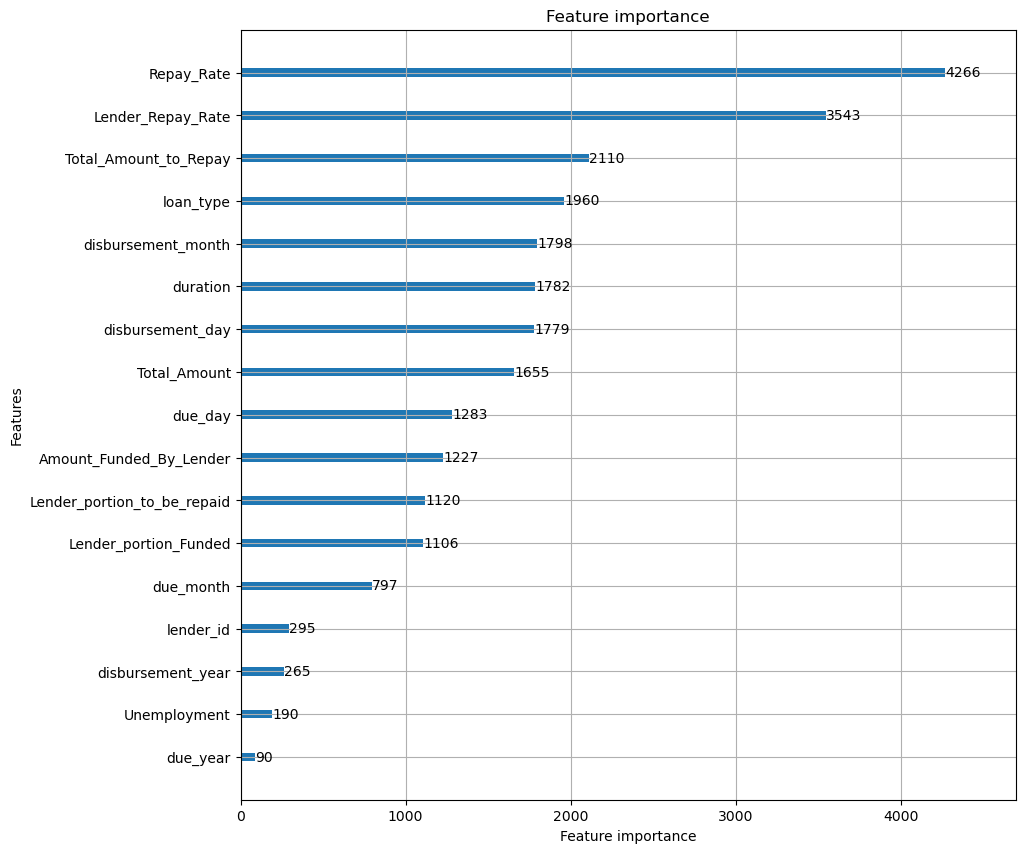

In [50]:
model = make_pipeline(
    exctraction,
    #selection,
    LGBMClassifier(n_estimators=1000, learning_rate=0.01, num_leaves=31, max_depth=5, random_state=42, verbose=-1, class_weight='balanced', n_jobs=-1)
)

model.fit(X_train, y_train)
print(classification_report(y_train, model.predict(X_train)))
print(classification_report(y_test, model.predict(X_test)))

lgb_plot_importance(model.named_steps['lgbmclassifier'], figsize=(10, 10))

## Model

In [35]:
df_train = preprocess(train, indicator)

X, y = df_train.drop(columns='target'), df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   loan_type                    68654 non-null  object 
 2   Total_Amount                 68654 non-null  float64
 3   Total_Amount_to_Repay        68654 non-null  float64
 4   duration                     68654 non-null  int64  
 5   New_versus_Repeat            68654 non-null  object 
 6   Amount_Funded_By_Lender      68654 non-null  float64
 7   Lender_portion_Funded        68654 non-null  float64
 8   Lender_portion_to_be_repaid  68654 non-null  float64
 9   target                       68654 non-null  int64  
 10  disbursement_year            68654 non-null  int64  
 11  disbursement_month           68654 non-null  int64  
 12  disbursement_day             68654 non-null  int64  
 13  due_year        

### Baseline

In [36]:
model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
      (make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()), make_column_selector(dtype_include=np.float64)),
      (SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=np.int64)),
      remainder='drop',
      verbose_feature_names_out=False
    ),
    LogisticRegression(),
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

Train f1-score: 0.6407612881924687
Validation f1-score: 0.6399768150665233

Test report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13479
           1       0.74      0.53      0.62       252

    accuracy                           0.99     13731
   macro avg       0.87      0.76      0.81     13731
weighted avg       0.99      0.99      0.99     13731



### Models

### Boosting Models

In [37]:
model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
      (SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.float64)),
      (SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=np.int64)),
      #(make_pipeline(SimpleImputer(strategy='most_frequent'), TargetEncoder()), make_column_selector(dtype_include=object)),
      remainder='drop',
      verbose_feature_names_out=False
    ),
    LGBMClassifier(random_state=42, n_estimators=50, max_depth=5, verbose=-1)
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

Train f1-score: 0.9034024308566355
Validation f1-score: 0.8519224410617916

Test report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.85      0.84      0.85       252

    accuracy                           0.99     13731
   macro avg       0.93      0.92      0.92     13731
weighted avg       0.99      0.99      0.99     13731



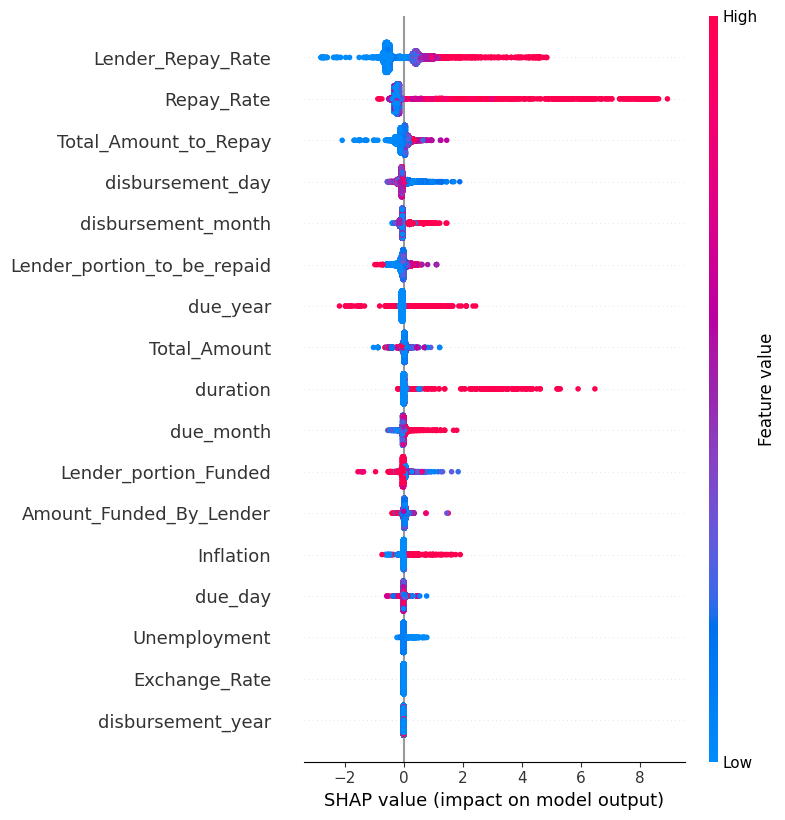

In [38]:
shap.initjs()

filter = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
      (SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.float64)),
      (SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=np.int64)),
      #(make_pipeline(SimpleImputer(strategy='most_frequent'), TargetEncoder()), make_column_selector(dtype_include=object)),
      remainder='drop',
      verbose_feature_names_out=False
    )
)

filter.fit(X_train, y_train)

explainer = shap.TreeExplainer(model.named_steps['lgbmclassifier'])
shap_values = explainer.shap_values(filter.transform(X_test))

shap.summary_plot(shap_values, filter.transform(X_test))

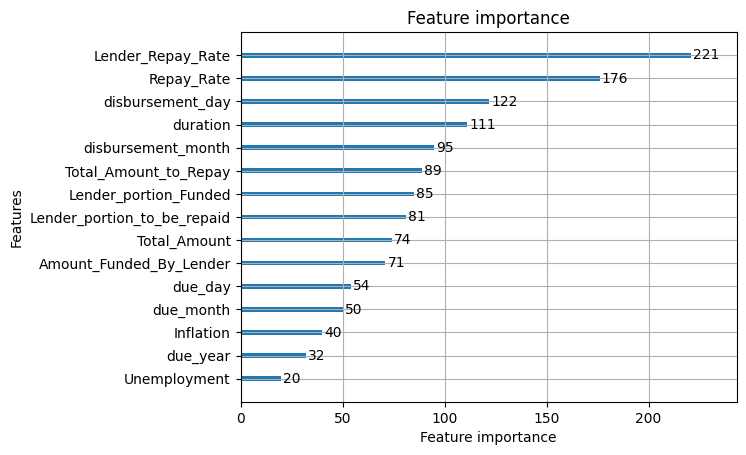

In [39]:
lgb_plot_importance(model.named_steps['lgbmclassifier']);

### Logistic Regression with PCA

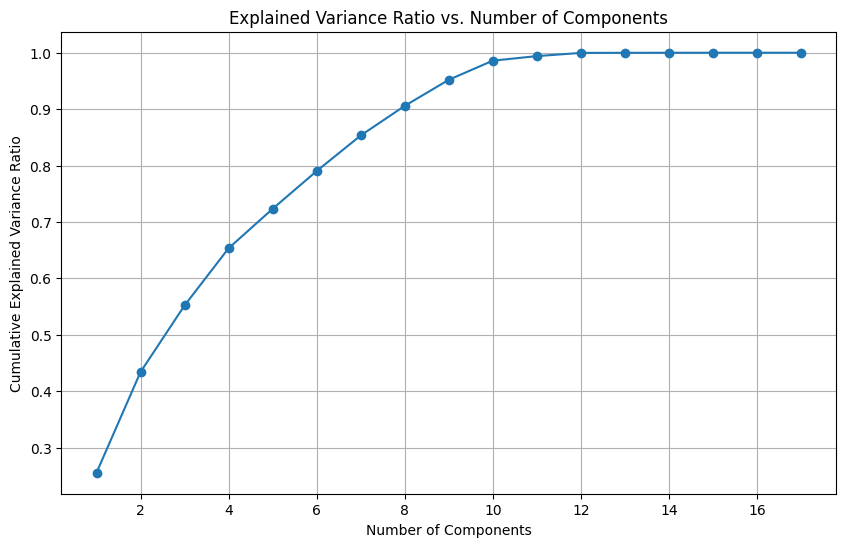

In [40]:
import matplotlib.pyplot as plt

pca = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False,
    ),
    make_column_transformer(
      (SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.float64)),
      (SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=np.int64)),
      #(make_pipeline(SimpleImputer(strategy='most_frequent'), TargetEncoder()), make_column_selector(dtype_include=object)),
      remainder='drop',
      verbose_feature_names_out=False,
    ),
    StandardScaler(),
    PCA()
)

X_train_pca = pca.fit_transform(X_train, y_train)

explained_variance_ratio = pca.named_steps["pca"].explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio vs. Number of Components")
plt.grid(True)
plt.show()

In [41]:
model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
      (make_pipeline(SimpleImputer(strategy="mean")), make_column_selector(dtype_include=np.float64)),
      (SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=np.int64)),
      #(make_pipeline(SimpleImputer(strategy='most_frequent'), TargetEncoder()), make_column_selector(dtype_include=object)),
      remainder='drop',
      verbose_feature_names_out=False
    ),
    StandardScaler(),
    PCA(n_components=8),
    LogisticRegression(),
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

Train f1-score: 0.6284170576531674
Validation f1-score: 0.6291833269646945

Test report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13479
           1       0.75      0.53      0.62       252

    accuracy                           0.99     13731
   macro avg       0.87      0.76      0.81     13731
weighted avg       0.99      0.99      0.99     13731



### Feature selection

In [62]:
continuous_columns = [
    #'Total_Amount',
    'Total_Amount_to_Repay',
    #'Amount_Funded_By_Lender',
    'Lender_portion_Funded',
    'Lender_portion_to_be_repaid',
    'Repay_Rate',
    #'Lender_Repay_Rate',
    'Inflation',
    #'Unemployment',
    #'Exchange_Rate',
]

discrete_columns = [
    'duration',
    #'disbursement_year',
    'disbursement_month',
    #'disbursement_day',
    #'due_year',
    #'due_month',
    #'due_day',
]

categorical_columns = [
    'loan_type',
    'New_versus_Repeat',
]

### Boosting with Hyperparameter tuning

In [71]:
model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        #(make_pipeline(SimpleImputer(strategy='most_frequent'), TargetEncoder()), categorical_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    #RandomOverSampler(random_state=42),
    SMOTE(random_state=42, sampling_strategy=0.3),
    #RandomUnderSampler(random_state=42, sampling_strategy=0.3),
    LGBMClassifier(random_state=42, n_estimators=50, max_depth=5, verbose=-1)
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

Train f1-score: 0.7959875465078958
Validation f1-score: 0.7782733371673591

Test report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13479
           1       0.63      0.95      0.76       252

    accuracy                           0.99     13731
   macro avg       0.81      0.97      0.88     13731
weighted avg       0.99      0.99      0.99     13731



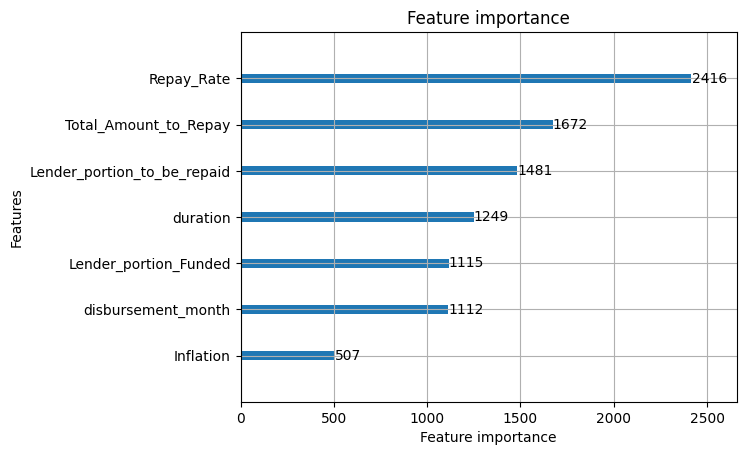

In [128]:
lgb_plot_importance(model.named_steps['lgbmclassifier']);

In [76]:
def evaluate(max_depth, learning_rate, lambda_l1, lambda_l2, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'random_state': 42,
        'n_jobs': -1,
        "verbose": -1,
    }

    model = make_pipeline(
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        LGBMClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2),
    'n_estimators': (50, 500),
    'thresh': (0.5, 0.5),
    'lambda_l1': (0.1, 1.0),
    'lambda_l2': (0.1, 1.0),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    LGBMClassifier(
        max_depth=int(best_params['max_depth']),
        learning_rate=best_params['learning_rate'],
        n_estimators=int(best_params['n_estimators']),
        lambda_l1=best_params['lambda_l1'],
        lambda_l2=best_params['lambda_l2'],
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | n_esti... |  thresh   |
-------------------------------------------------------------------------------------------------
| 1         | 0.0       | 0.4371    | 0.9556    | 0.1491    | 7.191     | 120.2     | 0.5       |
| 2         | 0.0       | 0.1523    | 0.8796    | 0.1242    | 7.957     | 59.26     | 0.5       |
| 3         | 0.8452    | 0.8492    | 0.2911    | 0.04455   | 4.284     | 186.9     | 0.5       |
| 4         | 0.0       | 0.4888    | 0.3621    | 0.1263    | 3.976     | 181.5     | 0.5       |
| 5         | 0.0       | 0.5105    | 0.8067    | 0.04794   | 6.6       | 316.6     | 0.5       |
| 6         | 0.0       | 0.6468    | 0.2535    | 0.02236   | 9.642     | 484.5     | 0.5       |
| 7         | 0.0       | 0.3742    | 0.1879    | 0.14      | 6.081     | 104.9     | 0.5       |
| 8         | 0.0       | 0.1309    | 0.9184    | 0.05917   | 7.638     | 190.3     | 0.5       |
| 9         | 0.0   

In [80]:
def evaluate(max_depth, learning_rate, lambda_l1, lambda_l2, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'random_state': 42,
        'n_jobs': -1,
        "verbose": -1,
    }

    model = make_pipeline(
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        SMOTE(random_state=42, sampling_strategy=0.3),
        LGBMClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2),
    'n_estimators': (50, 500),
    'thresh': (0.5, 0.5),
    'lambda_l1': (0.1, 1.0),
    'lambda_l2': (0.1, 1.0),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    SMOTE(random_state=42, sampling_strategy=0.3),
    LGBMClassifier(
        max_depth=int(best_params['max_depth']),
        learning_rate=best_params['learning_rate'],
        n_estimators=int(best_params['n_estimators']),
        lambda_l1=best_params['lambda_l1'],
        lambda_l2=best_params['lambda_l2'],
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | n_esti... |  thresh   |
-------------------------------------------------------------------------------------------------
| 1         | 0.0       | 0.4371    | 0.9556    | 0.1491    | 7.191     | 120.2     | 0.5       |
| 2         | 0.8123    | 0.1523    | 0.8796    | 0.1242    | 7.957     | 59.26     | 0.5       |
| 3         | 0.7839    | 0.8492    | 0.2911    | 0.04455   | 4.284     | 186.9     | 0.5       |
| 4         | 0.8112    | 0.4888    | 0.3621    | 0.1263    | 3.976     | 181.5     | 0.5       |
| 5         | 0.0       | 0.5105    | 0.8067    | 0.04794   | 6.6       | 316.6     | 0.5       |
| 6         | 0.0       | 0.6468    | 0.2535    | 0.02236   | 9.642     | 484.5     | 0.5       |
| 7         | 0.0       | 0.3742    | 0.1879    | 0.14      | 6.081     | 104.9     | 0.5       |
| 8         | 0.0       | 0.1309    | 0.9184    | 0.05917   | 7.638     | 190.3     | 0.5       |
| 9         | 0.0   

In [81]:
def evaluate(max_depth, learning_rate, lambda_l1, lambda_l2, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'random_state': 42,
        'n_jobs': -1,
        "verbose": -1,
    }

    model = make_pipeline(
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        #SMOTE(random_state=42, sampling_strategy=0.3),
        LGBMClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2),
    'n_estimators': (50, 500),
    'thresh': (0.05, 0.5),
    'lambda_l1': (0.1, 1.0),
    'lambda_l2': (0.1, 1.0),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    #SMOTE(random_state=42, sampling_strategy=0.3),
    LGBMClassifier(
        max_depth=int(best_params['max_depth']),
        learning_rate=best_params['learning_rate'],
        n_estimators=int(best_params['n_estimators']),
        lambda_l1=best_params['lambda_l1'],
        lambda_l2=best_params['lambda_l2'],
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | n_esti... |  thresh   |
-------------------------------------------------------------------------------------------------
| 1         | 0.0       | 0.4371    | 0.9556    | 0.1491    | 7.191     | 120.2     | 0.1202    |
| 2         | 0.0       | 0.1523    | 0.8796    | 0.1242    | 7.957     | 59.26     | 0.4865    |
| 3         | 0.8452    | 0.8492    | 0.2911    | 0.04455   | 4.284     | 186.9     | 0.2861    |
| 4         | 0.0       | 0.4888    | 0.3621    | 0.1263    | 3.976     | 181.5     | 0.2149    |
| 5         | 0.0       | 0.5105    | 0.8067    | 0.04794   | 6.6       | 316.6     | 0.0709    |
| 6         | 0.0       | 0.6468    | 0.2535    | 0.02236   | 9.642     | 484.5     | 0.4138    |
| 7         | 0.0       | 0.3742    | 0.1879    | 0.14      | 6.081     | 104.9     | 0.2728    |
| 8         | 0.0       | 0.1309    | 0.9184    | 0.05917   | 7.638     | 190.3     | 0.284     |
| 9         | 0.0   

In [82]:
def evaluate(max_depth, learning_rate, lambda_l1, lambda_l2, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'random_state': 42,
        'n_jobs': -1,
        "verbose": -1,
    }

    model = make_pipeline(
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        SMOTE(random_state=42, sampling_strategy=0.3),
        LGBMClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2),
    'n_estimators': (50, 500),
    'thresh': (0.05, 0.5),
    'lambda_l1': (0.1, 1.0),
    'lambda_l2': (0.1, 1.0),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    SMOTE(random_state=42, sampling_strategy=0.3),
    LGBMClassifier(
        max_depth=int(best_params['max_depth']),
        learning_rate=best_params['learning_rate'],
        n_estimators=int(best_params['n_estimators']),
        lambda_l1=best_params['lambda_l1'],
        lambda_l2=best_params['lambda_l2'],
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | n_esti... |  thresh   |
-------------------------------------------------------------------------------------------------
| 1         | 0.0       | 0.4371    | 0.9556    | 0.1491    | 7.191     | 120.2     | 0.1202    |
| 2         | 0.8123    | 0.1523    | 0.8796    | 0.1242    | 7.957     | 59.26     | 0.4865    |
| 3         | 0.7839    | 0.8492    | 0.2911    | 0.04455   | 4.284     | 186.9     | 0.2861    |
| 4         | 0.8112    | 0.4888    | 0.3621    | 0.1263    | 3.976     | 181.5     | 0.2149    |
| 5         | 0.0       | 0.5105    | 0.8067    | 0.04794   | 6.6       | 316.6     | 0.0709    |
| 6         | 0.0       | 0.6468    | 0.2535    | 0.02236   | 9.642     | 484.5     | 0.4138    |
| 7         | 0.0       | 0.3742    | 0.1879    | 0.14      | 6.081     | 104.9     | 0.2728    |
| 8         | 0.0       | 0.1309    | 0.9184    | 0.05917   | 7.638     | 190.3     | 0.284     |
| 9         | 0.0   

### Random Forest with Hyperparaeter tuning

In [8]:
model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

Train f1-score: 0.8119323295890671
Validation f1-score: 0.7920960012157537

Test report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13479
           1       0.93      0.71      0.80       252

    accuracy                           0.99     13731
   macro avg       0.96      0.85      0.90     13731
weighted avg       0.99      0.99      0.99     13731



In [10]:
def evaluate(max_depth, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'random_state': 42,
        'n_jobs': -1,
    }

    model = make_pipeline(
        #RandomOverSampler(random_state=42),
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        RandomForestClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'n_estimators': (50, 500),
    'thresh': (0.5, 0.5),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    RandomForestClassifier(
        max_depth=int(best_params['max_depth']),
        n_estimators=int(best_params['n_estimators']),
        random_state=42,
        n_jobs=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

|   iter    |  target   | max_depth | n_esti... |  thresh   |
-------------------------------------------------------------
| 1         | 0.7896    | 5.622     | 477.8     | 0.5       |
| 2         | 0.0       | 7.191     | 120.2     | 0.5       |
| 3         | 0.3004    | 3.407     | 439.8     | 0.5       |
| 4         | 0.0       | 7.957     | 59.26     | 0.5       |
| 5         | 0.0       | 8.827     | 145.6     | 0.5       |
| 6         | 0.6791    | 4.284     | 186.9     | 0.5       |
| 7         | 0.8081    | 6.024     | 181.1     | 0.5       |
| 8         | 0.1063    | 3.976     | 181.5     | 0.5       |
| 9         | 0.8068    | 6.192     | 403.3     | 0.5       |
| 10        | 0.8055    | 6.6       | 316.6     | 0.5       |
| 11        | 0.8068    | 6.257     | 403.3     | 0.5       |
| 12        | 0.0       | 7.841     | 181.0     | 0.5       |
| 13        | 0.0       | 7.157     | 315.5     | 0.5       |
| 14        | 0.8055    | 6.088     | 317.0     | 0.5       |
| 15    

In [ ]:
def evaluate(max_depth, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'random_state': 42,
        'n_jobs': -1,
    }

    model = make_pipeline(
        #RandomOverSampler(random_state=42),
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        RandomForestClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'n_estimators': (50, 500),
    'thresh': (0.1, 0.5),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    RandomForestClassifier(
        max_depth=int(best_params['max_depth']),
        n_estimators=int(best_params['n_estimators']),
        random_state=42,
        n_jobs=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

|   iter    |  target   | max_depth | n_esti... |  thresh   |
-------------------------------------------------------------


In [ ]:
def evaluate(max_depth, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'random_state': 42,
        'n_jobs': -1,
    }

    model = make_pipeline(
        #RandomOverSampler(random_state=42),
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        SMOTE(random_state=42, sampling_strategy=0.3),
        RandomForestClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'n_estimators': (50, 500),
    'thresh': (0.5, 0.5),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    SMOTE(random_state=42, sampling_strategy=0.3),
    RandomForestClassifier(
        max_depth=int(best_params['max_depth']),
        n_estimators=int(best_params['n_estimators']),
        random_state=42,
        n_jobs=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

In [84]:
def evaluate(max_depth, n_estimators, thresh):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'random_state': 42,
        'n_jobs': -1,
    }

    model = make_pipeline(
        #RandomOverSampler(random_state=42),
        make_column_transformer(
            ('drop', ['ID']),
            remainder='passthrough',
            verbose_feature_names_out=False
        ),
        make_column_transformer(
            (SimpleImputer(strategy="mean"), continuous_columns),
            (SimpleImputer(strategy='most_frequent'), discrete_columns),
            remainder='drop',
            verbose_feature_names_out=False
        ),
        SMOTE(random_state=42, sampling_strategy=0.3),
        RandomForestClassifier(**params)
    )
    model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

    val_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()

    return val_score if abs(val_score - train_score) < 0.05 else 0.0

param_space = {
    'max_depth': (3, 10),
    'n_estimators': (50, 500),
    'thresh': (0.05, 0.5),
}

optimizer = BayesianOptimization(f=evaluate, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']

model = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (SimpleImputer(strategy="mean"), continuous_columns),
        (SimpleImputer(strategy='most_frequent'), discrete_columns),
        remainder='drop',
        verbose_feature_names_out=False
    ),
    SMOTE(random_state=42, sampling_strategy=0.3),
    RandomForestClassifier(
        max_depth=int(best_params['max_depth']),
        n_estimators=int(best_params['n_estimators']),
        random_state=42,
        n_jobs=-1,
    )
)
model.predict = lambda X: (model.predict_proba(X) > best_params["thresh"]).argmax(axis=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)

print(f"Train f1-score: {cv_results['train_score'].mean()}")
print(f"Validation f1-score: {cv_results['test_score'].mean()}")

print("\nTest report:")
print(classification_report(y_test, y_pred))

|   iter    |  target   | max_depth | n_esti... |  thresh   |
-------------------------------------------------------------
| 1         | 0.694     | 5.622     | 477.8     | 0.3794    |
| 2         | 0.7513    | 7.191     | 120.2     | 0.1202    |
| 3         | 0.6901    | 3.407     | 439.8     | 0.3205    |
| 4         | 0.7512    | 7.957     | 59.26     | 0.4865    |
| 5         | 0.7739    | 8.827     | 145.6     | 0.1318    |
| 6         | 0.6993    | 4.284     | 186.9     | 0.2861    |
| 7         | 0.7176    | 6.024     | 181.1     | 0.3253    |
| 8         | 0.6938    | 3.976     | 181.5     | 0.2149    |
| 9         | 0.716     | 6.192     | 403.3     | 0.1399    |
| 10        | 0.7171    | 6.6       | 316.6     | 0.0709    |
| 11        | 0.7206    | 6.14      | 145.1     | 0.1791    |
| 12        | 0.7874    | 9.612     | 145.1     | 0.1164    |
| 13        | 0.7874    | 9.219     | 142.5     | 0.4482    |
| 14        | 0.7871    | 9.735     | 138.1     | 0.2047    |
| 15    

### Deep Neural Network

In [58]:
transform = make_pipeline(
    make_column_transformer(
        ('drop', ['ID']),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    make_column_transformer(
        (make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()), make_column_selector(dtype_include=np.float64)),
        (SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=np.int64)),
        remainder='drop',
        verbose_feature_names_out=False
    ),
)

X_train_transformed = transform.fit_transform(X_train)
X_test_transformed = transform.transform(X_test)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_transformed.shape[1],)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'f1_score'])

model.fit(X_train_transformed, y_train, epochs=10, batch_size=32)

loss, accuracy, f1_score = model.evaluate(X_test_transformed, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test F1 score: {f1_score}")

Epoch 1/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9642 - f1_score: 0.0391 - loss: 2.4011
Epoch 2/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9836 - f1_score: 0.0408 - loss: 0.1119
Epoch 3/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9866 - f1_score: 0.0356 - loss: 0.0572
Epoch 4/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9864 - f1_score: 0.0375 - loss: 0.0568
Epoch 5/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9882 - f1_score: 0.0363 - loss: 0.0401
Epoch 6/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9879 - f1_score: 0.0356 - loss: 0.0417
Epoch 7/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9877 - f1_score: 0.0352 - loss: 0.0397
Epoch 8/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9889 - f1_score: 0.0355 - loss: 0.0363
Epoch 9/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9889 - f1_score: 0.0361 - loss: 0.0343
Epoch 10/10
1717/1717 ━━━━━━━━━━━━━━━

### Submission

In [11]:
# Make submission

df_test = preprocess(test, indicator)

model.fit(X, y)

y_pred = model.predict(df_test)

submission = pd.DataFrame({
    "ID": test["ID"],
    "target": y_pred
})

submission.to_csv("submission.csv", index=False)

---